In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!cp -r drive/MyDrive/IFT780/projet_session_hiver/TP2/progTP2/prog/* .

Mounted at /content/drive


# Pytorch

Dans ce notebook, nous reproduirons le modèle conçu dans le notebook précédent, mais avec Pytorch !
Pytorch est une bibliothèque permettant de concevoir et entraîner des réseaux de neurones facilement, gérant pour vous la propagation entre les couches, la rétropropagation, l'optimisation du modèle, l'utilisation du GPU, et plus.

Pour commencer, il est conseillé de lire en bonne partie l'introduction à Pytorch ici:
https://pytorch.org/tutorials/beginner/basics/intro.html

In [1]:
import random
import numpy as np
from utils.data_utils import load_CIFAR10, display_images
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Pour automatiquement recharger les modules externes
# voir http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
%cd datasets
!ls
!bash -x ./get_datasets.sh
%cd ../

/content/datasets
cifar-10-batches-py  get_datasets.sh  stripes.jpg  wolf.jpg
+ wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
--2023-03-02 18:30:03--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  16.7MB/s    in 9.7s    

2023-03-02 18:30:14 (16.8 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

+ tar -xzvf cifar-10-python.tar.gz
cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
+ rm cifar-10

In [2]:
from layers.BatchNorm import SpatialBatchNorm
from layers.Conv import Conv2DCython
from layers.Dense import Dense
from layers.Flatten import Flatten
from layers.MaxPool import MaxPool2DCython
from layers.Dropout import Dropout
from model.Model import Model
from utils.model_loss import cross_entropy_loss
from model.Solver import epoch_solver, Adam

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500, num_batch=200):
    """
    Charger la banque de données CIFAR-10, prétraiter les images et ajouter une dimension pour le biais.
    
    Input :
    - num_training : nombre d'images à mettre dans l'ensemble d'entrainement
    - num_validation : nombre d'images à mettre dans l'ensemble de validation
    - num_test : nombre d'images à mettre dans l'ensemble de test
    - num_dev : d'images à mettre dans l'ensemble dev
    
    Output :
    - X_train, y_train : données et cibles d'entrainement
    - X_val, y_val: données et cibles de validation
    - X_test y_test: données et cibles de test 
    - X_dev, y_dev: données et cibles dev
    - X_batch, y_batch: batch de données et de cibles 
    """
    # Charger les données CIFAR-10
    cifar10_dir = 'datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test, label_names = load_CIFAR10(cifar10_dir)
  
    # Séparer en ensembles d'entraînement, de validation, de test et de dev
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    mask = range(num_batch)
    X_batch = X_train[mask]
    y_batch = y_train[mask]
    
    X_train = X_train.transpose(0, 3, 1, 2)
    X_test = X_test.transpose(0, 3, 1, 2)
    X_val = X_val.transpose(0, 3, 1, 2)
    X_dev = X_dev.transpose(0, 3, 1, 2)

    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev, X_batch, y_batch, label_names 

def preprocess_CIFAR10_data(X):

    # Normalisation
    X_mean = np.mean(X, axis = 0)
    X_ = X - X_mean
    
    return X_

Data_train, y_train, Data_val, y_val, Data_test, y_test, Data_dev, y_dev, Data_batch, y_batch, label_names = get_CIFAR10_data()
X_train, X_val, X_test, X_dev, X_batch, = (preprocess_CIFAR10_data(Data) for Data in (Data_train, Data_val, Data_test, Data_dev, Data_batch))

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)
print('batch data shape: ', X_batch.shape)
print('batch labels shape: ', y_batch.shape)

print("CIFAR10 est un jeu de données d'images RGB 32x32x3 séparées en 10 classes")
print(label_names)

Train data shape:  (49000, 3, 32, 32)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3, 32, 32)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3, 32, 32)
Test labels shape:  (1000,)
dev data shape:  (500, 3, 32, 32)
dev labels shape:  (500,)
batch data shape:  (200, 32, 32, 3)
batch labels shape:  (200,)
CIFAR10 est un jeu de données d'images RGB 32x32x3 séparées en 10 classes
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Modèle en numpy

Premièrement, recréons le modèle précédemment implémenté:

In [3]:
# paramètres de convolution, à modifier au besoin
filter_size = 5
channels = 3
stride = 1
p_dropout = 0.1
pad = int((filter_size - 1)/2)

# paramètres dense
num_classes = 10

def create_Nlayer_cnn(num_filter_layer1, num_filter_layer2, fc_size, init_weight_scale):
    model = Model()
    
    currentFilter = num_filter_layer1
    currentChannels = channels

    for i in range(3):
        if i == 1:
            currentFilter = num_filter_layer2
            currentChannels = num_filter_layer1
        elif i == 2:
            currentFilter = fc_size
            currentChannels = num_filter_layer2

        model.add(Conv2DCython(currentFilter,filter_size=filter_size,channels=currentChannels,stride=stride,padding=pad,weight_scale=init_weight_scale,activation='relu'))
        model.add(SpatialBatchNorm(currentFilter, weight_scale=init_weight_scale))

        if i != 2:
            model.add(MaxPool2DCython())
            
        model.add(Dropout(p_dropout))

    model.add(Flatten())
    model.add(Dense(dim_input=fc_size * 28 * 28, dim_output=num_classes, weight_scale=init_weight_scale))
    model.add_loss(cross_entropy_loss)
    
    return model    

reg = 1e-2 # à ajuster au besoin
lr = 5e-4  # à ajuster au besoin
model = create_Nlayer_cnn(32, 16, 400, 1e-2)

optimizer = Adam(lr, model)
    
# On entraîne (1 epoch) avec 100% des données d'entraînement.
loss_history, train_accuracy_history, val_accuracy_history = epoch_solver(X_train, 
                                                                          y_train,
                                                                          X_val,
                                                                          y_val,
                                                                          reg,
                                                                          optimizer,
                                                                          batch_size=100,
                                                                          epochs=1)

(batch 20 / 490) loss: 2.473071
(batch 40 / 490) loss: 1.926401
(batch 60 / 490) loss: 1.822685
(batch 80 / 490) loss: 1.759695
(batch 100 / 490) loss: 1.660237
(batch 120 / 490) loss: 1.464999
(batch 140 / 490) loss: 1.363986
(batch 160 / 490) loss: 1.548340
(batch 180 / 490) loss: 1.420576
(batch 200 / 490) loss: 1.371783
(batch 220 / 490) loss: 1.524949
(batch 240 / 490) loss: 1.635254
(batch 260 / 490) loss: 1.444339
(batch 280 / 490) loss: 1.388580
(batch 300 / 490) loss: 1.524846
(batch 320 / 490) loss: 1.344959
(batch 340 / 490) loss: 1.339108
(batch 360 / 490) loss: 1.288445
(batch 380 / 490) loss: 1.449322
(batch 400 / 490) loss: 1.480781
(batch 420 / 490) loss: 1.465040
(batch 440 / 490) loss: 1.377545
(batch 460 / 490) loss: 1.295758
(batch 480 / 490) loss: 1.351505
(epoch 1 / 1) loss: 1.177525, train_acc: 0.592286, val_acc: 0.569000


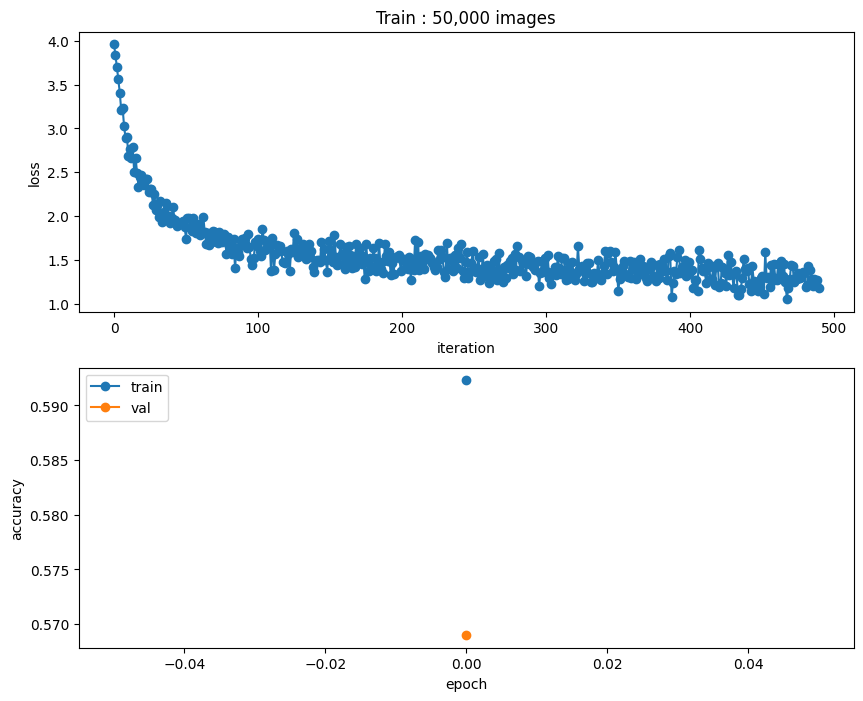

In [4]:
plt.subplot(2, 1, 1)
plt.plot(loss_history, '-o')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Train : 50,000 images')

plt.subplot(2, 1, 2)
plt.plot(train_accuracy_history, '-o')
plt.plot(val_accuracy_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [5]:
y_test_pred = model.predict(X_test)
#trop de RAM pour google collab
test_acc = (y_test_pred == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.585


## Modèle en pytorch

Maintenant, recréons le modèle avec Pytorch. Tout d'abord, un peu de mise en place.

In [6]:
import os
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cpu device


In [7]:
# On se crée tout d'abord un dataset permettant d'acceuillir les données
# À noter que Pytorch offre déjà des façons de charger CIFAR-10, mais pour les besoins de la cause
# faisons-le nous-même:

params = {'batch_size': 100,
          'shuffle': False,
          'num_workers': 1}

class CIFAR10Dataset(torch.utils.data.Dataset):
  def __init__(self, data, labels):
        self.labels = labels
        self.data = data

  def __len__(self):
        return len(self.data)

  def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]

        return x, y


# Alors que le dataset permet d'accéder aux données, le "DataLoader" permet de les charger en "batch" (et
# potentiellement avec plusieurs workers)
train_pyt = CIFAR10Dataset(X_train, y_train)
training_generator = torch.utils.data.DataLoader(train_pyt, **params)

valid_pyt = CIFAR10Dataset(X_val, y_val)
valid_generator = torch.utils.data.DataLoader(valid_pyt, **params)

test_pyt = CIFAR10Dataset(X_test, y_test)
test_generator = torch.utils.data.DataLoader(test_pyt, **params)

In [11]:
from torch.nn.modules import padding
# paramètres de convolution, à modifier au besoin
filter_size = 5
channels = 3
stride = 1
p_dropout = 0.1
pad = int((filter_size - 1)/2)

# paramètres dense
num_classes = 10


# On se crée une classe pour notre modèle
class NeuralNetwork(nn.Module):
    def __init__(self, stack: nn.Sequential):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.stack = stack
        
    def forward(self, x):
        out = self.stack(x)
        return out

# On emboîte les layers dans nn.Sequential, permettant de simplifier le code de la propagation avant
# Ce n'est pas nécéssaire en général, mais pour simplifier le code du travail pratique, on le fait comme ça:
def create_cnn_stack(num_filter_layer1, num_filter_layer2, fc_size, init_weight_scale):
    
    # TODO: Convertir votre modèle numpy en modules pytorch   
    # remplater -1 par le modèle créé

    stack = nn.Sequential(
        nn.Conv2d(in_channels = channels, out_channels = num_filter_layer1,  kernel_size = filter_size, stride = stride, padding = pad),
        nn.ReLU(inplace = True),
        nn.BatchNorm2d(num_filter_layer1),
        nn.MaxPool2d(3),
        nn.Dropout(p_dropout),

        #couche 2
        nn.Conv2d(in_channels = num_filter_layer1, out_channels = num_filter_layer2,  kernel_size = filter_size, stride = stride, padding = pad),
        nn.ReLU(inplace = True),
        nn.BatchNorm2d(num_filter_layer2),
        nn.MaxPool2d(3),
        nn.Dropout(p_dropout),

        #couche 3
        nn.Conv2d(in_channels = num_filter_layer2, out_channels = fc_size,  kernel_size = filter_size, stride = stride, padding= pad),
        nn.ReLU(inplace = True),
        nn.BatchNorm2d(fc_size),
        nn.Dropout(p_dropout),

        #couche sortie
        nn.Flatten(),
        nn.Linear(3600, num_classes))
    
    #weight scale : std
    #initialiser poids
    def initialiser_poids(model):
        classname = model.__class__.__name__
        if classname.find('Linear') != -1 or classname.find('Conv2d') != -1 :
          model.weight.data.normal_(0.0, init_weight_scale)
          model.bias.data.fill_(0)
    
    stack.apply(initialiser_poids)
    return stack


In [12]:
reg = 1e-2 # à ajuster au besoin
lr = 5e-4  # à ajuster au besoin
stack = create_cnn_stack(32, 16, 400, 1e-2)

# On instancie le modèle en y passant la "stack" le couches
model_pyt = NeuralNetwork(stack).to(device)

# On se déclare un optimiseur qui effectuera la descente de gradient
optimizer_pyt = optim.Adam(model_pyt.parameters(), lr=lr, weight_decay=reg)

# On se déclare une loss
loss_fn = nn.CrossEntropyLoss()

loss_history, train_accuracy_history, valid_accuracy_history = [], [], []

# On optimise ! Le code plus bas remplace la classe Solver précédemment définie
epochs = 1
for epoch in range(epochs):
    training_accuracy = []
    valid_accuracy = []
    for i, (batch, labels) in enumerate(training_generator):

        batch = batch.float().to(device)
        if device == 'cuda':
            batch = batch.cuda()
        labels = labels.to(device)
        
        logits = model_pyt(batch)
        preds = torch.argmax(logits, dim=-1)
        accuracy = torch.sum(preds == labels) / len(batch)
        
        loss = loss_fn(logits, labels)
        
        optimizer_pyt.zero_grad()
        loss.backward()
        optimizer_pyt.step()
        
        training_accuracy.append(accuracy)
        loss_history.append(loss.detach().numpy())
        
        if i % 20 == 0:
            print('batch {} / {} loss : {}'.format(i, len(training_generator), loss))
            
    with torch.no_grad():
        for i, (batch, labels) in enumerate(valid_generator):
            batch = batch.float().to(device)
            if device == 'cuda':
                batch = batch.cuda()
            labels = labels.to(device)
        
            logits = model_pyt(batch)
            preds = torch.argmax(logits, dim=-1)
            accuracy = torch.sum(preds == labels) / len(batch)
            valid_accuracy.append(accuracy)
            
    mean_epoch_train_acc = torch.mean(torch.stack(training_accuracy))        
    mean_epoch_valid_acc = torch.mean(torch.stack(valid_accuracy))     
    train_accuracy_history.append(mean_epoch_train_acc)
    valid_accuracy_history.append(mean_epoch_valid_acc)
    print(f"(epoch {epoch + 1} / {epochs}) loss: {loss}, train_acc: {mean_epoch_train_acc}, val_acc: {mean_epoch_valid_acc}")

batch 0 / 490 loss : 2.508340358734131
batch 20 / 490 loss : 2.216066837310791
batch 40 / 490 loss : 1.604170799255371
batch 60 / 490 loss : 1.6765735149383545
batch 80 / 490 loss : 1.574418544769287
batch 100 / 490 loss : 1.354312777519226
batch 120 / 490 loss : 1.5325567722320557
batch 140 / 490 loss : 1.5944207906723022
batch 160 / 490 loss : 1.4018981456756592
batch 180 / 490 loss : 1.261574149131775
batch 200 / 490 loss : 1.573359727859497
batch 220 / 490 loss : 1.3955624103546143
batch 240 / 490 loss : 1.390394926071167
batch 260 / 490 loss : 1.107743263244629
batch 280 / 490 loss : 1.1697250604629517
batch 300 / 490 loss : 1.231040596961975
batch 320 / 490 loss : 1.4626669883728027
batch 340 / 490 loss : 1.2738076448440552
batch 360 / 490 loss : 1.3137588500976562
batch 380 / 490 loss : 1.2525821924209595
batch 400 / 490 loss : 1.0267888307571411
batch 420 / 490 loss : 1.322920322418213
batch 440 / 490 loss : 1.2412711381912231
batch 460 / 490 loss : 1.2067588567733765
batch 480

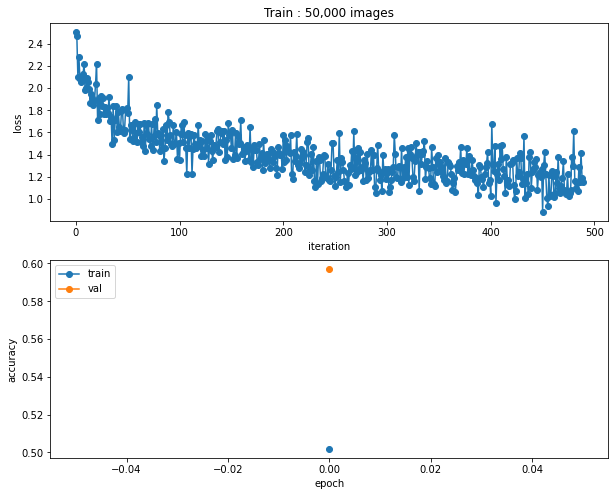

In [14]:
plt.subplot(2, 1, 1)
plt.plot(loss_history, '-o')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Train : 50,000 images')

plt.subplot(2, 1, 2)
plt.plot(train_accuracy_history, '-o')
plt.plot(valid_accuracy_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

Si tout s'est bien déroulé, vous devriez avoir une accuracy en validation et en test avec Pytorch semblable à celle en numpy !

Test accuracy:  0.59199995


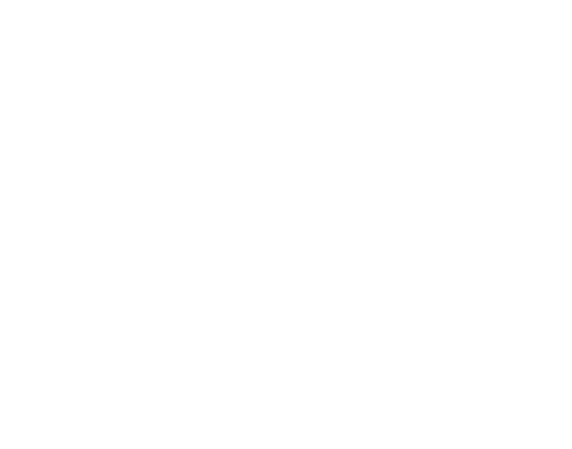

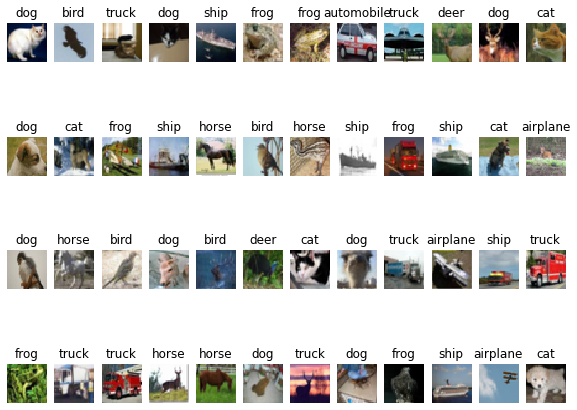

In [15]:
epochs = 1
test_accuracy = []
test_preds = []
with torch.no_grad():
    for i, (batch, labels) in enumerate(test_generator):
        batch = batch.float().to(device)
        if device == 'cuda':
            batch = batch.cuda()
        labels = labels.to(device)

        logits = model_pyt(batch)
        preds = torch.argmax(logits, dim=-1)
        accuracy = torch.sum(preds == labels) / len(batch)
        if device == 'cuda':
            accuracy = accuracy.cpu()
            preds = preds.cpu()
        test_accuracy.append(accuracy.numpy())
        test_preds.append(preds.numpy())

test_acc = np.mean(test_accuracy)
y_test_pred = np.concatenate(test_preds, axis=0)
print('Test accuracy: ', test_acc)

#display_images(np.swapaxes(np.swapaxes(Data_test,1,3),1,2), y_test_pred, label_names)
display_images(Data_test, y_test_pred, label_names)